### Load the dataset

In [16]:
!pip install -q -U einops datasets matplotlib tqdm



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [17]:
from torch import nn
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import ToTensor
import numpy as np
from torch.optim import Adam

In [18]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [19]:
class UpBlockWithCopy(nn.Module):
    def __init__(self, in_ch, out_ch):
        kernel_size = 3
        stride = 1
        padding = 1
        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        layers = [
            nn.ConvTranspose2d(2*in_ch, out_ch, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((skip, x), 1)
        return self.model(x)

In [30]:
# Time embeddings 
class EmbedNosieTimestamp(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim),
            nn.Unflatten(1, (output_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, time):
        time=time.view(-1, self.input_dim)
        return self.model(time)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()


False

In [28]:
import torch
import torchvision
from torchvision.transforms import Resize, Compose, ToTensor, Lambda, ToPILImage

import math
from inspect import isfunction
from functools import partial
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

def convertTensorToImage(img):
    reverse_transform = Compose([
        Lambda(lambda x: (x*2)+1),
        Lambda(lambda x: x*255),
        ToPILImage()
    ])

    return reverse_transform(img)

def convertImage(x):
    return (x*2)-1

def load_dataset_with_transform(image_size):
    data_transforms = Compose([
        Resize((image_size, image_size)),
        ToTensor(),
        convertImage
    ])

    dataset = torchvision.datasets.MNIST('./data/', transform=data_transforms, download=True)

    data_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=128,
                                            shuffle=True,
                                            num_workers=0)
    return data_loader

data = load_dataset_with_transform(28)

def visualize_conv_2d(sample, show_images=False):
    print("\nSample dimensions = ", sample.shape,)
    if show_images:
      plt.figure(figsize=(8,8))
      for c in range(len(sample)):
          print(c, sample[c].shape)
          cols =4
          rows = len(sample) // cols
          plt.subplot(rows+1,cols+1, c+1)
          plt.imshow(sample[c])


In [31]:
class UNetModel(nn.Module):
    def __init__(self, debug=False) -> None:
        super().__init__()
        down_sampling = [16, 32, 64]
        up_sampling = [64, 32, 16]
        self.debug = debug
        n_input_channels = 1
        latent_image_size = 7

        self.init_block = nn.Sequential(
            nn.Conv2d(n_input_channels, down_sampling[0], 3, padding=1),
            nn.BatchNorm2d(down_sampling[0]),
            nn.ReLU()
        )

        self.down1 = DownBlock(down_sampling[0], down_sampling[1])
        self.down2 = DownBlock(down_sampling[1], down_sampling[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_sampling[2]*latent_image_size**2, down_sampling[1]),
            nn.ReLU(),
            nn.Linear(down_sampling[1], down_sampling[1]),
            nn.ReLU(),
            nn.Linear(down_sampling[1], down_sampling[2]*latent_image_size**2),
            nn.ReLU()
        )
       
        self.time_embedding1 = EmbedNosieTimestamp(1, up_sampling[0])  
        self.time_embedding2 = EmbedNosieTimestamp(1, up_sampling[1])  

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_sampling[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_sampling[0], up_sampling[0], 3, padding=1),
            nn.BatchNorm2d(up_sampling[0]),
            nn.ReLU(),
        )

        self.up1 = UpBlockWithCopy(up_sampling[0], up_sampling[1])
        self.up2 = UpBlockWithCopy(up_sampling[1], up_sampling[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_sampling[-1], up_sampling[-1], 3, 1, 1),
            nn.BatchNorm2d(up_sampling[-1]),
            nn.ReLU(),
            nn.Conv2d(up_sampling[-1], n_input_channels, 3, 1, 1),
        )

    def forward(self, x, t):
        # print ("Running forward with image shape : ", x.shape)
        x = self.init_block(x)
        
        down1 = self.down1(x)
        down2 = self.down2(down1)
        x = self.to_vec(down2)

        x = self.dense_emb(x)
        tembed1 = self.time_embedding1(t)
        tembed2 = self.time_embedding2(t)

        x = self.up0(x)+tembed1
        up1 = self.up1(x, down2)+tembed2
        up2 = self.up2(up1, down1)
        out = self.out(up2)

        return out

model = UNetModel(debug=False).to(device)

print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  377665


### Loss function for noise
Inorder to predict noise, we can MSE mechanism to find the loss between original image and when noise is added.

In the example below, an image is taken and noise is added to it at various timesteps.

The loss function calcualtes the image data loss with the original and its increase as in the curve

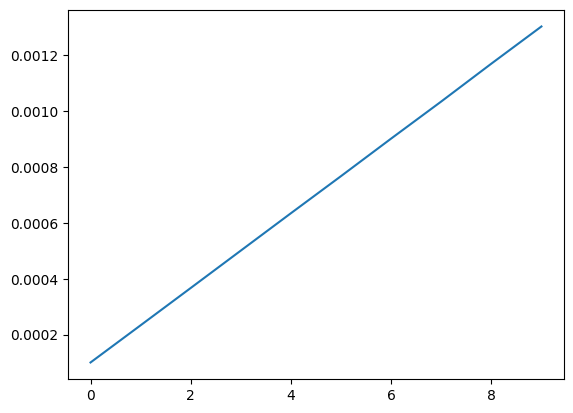

In [32]:
# image at certain step directly
input = Image.open("../ace_of_clubs.png")
input = ToTensor()(input)
beta = torch.linspace(0.0001, 0.02, 150)
iters = len(beta)
alpha = 1. - beta
alpha_cumu_prod = torch.cumprod(alpha, dim=0)

def getImageAtIter(iters, input):
    noise = torch.randn_like(input)
    x_t = torch.sqrt(1 - beta[iters]) * input + torch.sqrt(beta[iters]) * noise  # sample from q(x_t|x_t-1)
    return x_t

alpha_cumu_prod = torch.cumprod(alpha, dim=0)

# def getImageAtIter(iters, input):
#     alpha_val = alpha_cumu_prod[iters]
#     noise = torch.randn_like(input) * np.sqrt(1- alpha_val)
#     input = np.sqrt(alpha_val)*input + np.sqrt(alpha_val) * noise
#     return input

def loss_fun(a,b):
    return torch.nn.MSELoss()(a,b)

losses = [loss_fun(getImageAtIter(i, input), input) for i in range(10)]

plt.plot(losses)


The loss function can be used along with adam optimizer ar lr=0.0001 to learn about the loss.

In [36]:
optimizer = Adam(model.parameters(), lr=0.0001)
epochs = 10

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(data):
        optimizer.zero_grad()

        images = batch[0].to(device)
        t = torch.randint(0, iters, (128,), device=device)
        loss_added = getImageAtIter(t, images)
        lossy_images = model(loss_added).to(device)
        loss = loss_fun(lossy_images, images)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} Loss: {loss.item()} ")


RuntimeError: The size of tensor a (150) must match the size of tensor b (28) at non-singleton dimension 3

torch.Size([1, 1, 28, 28])


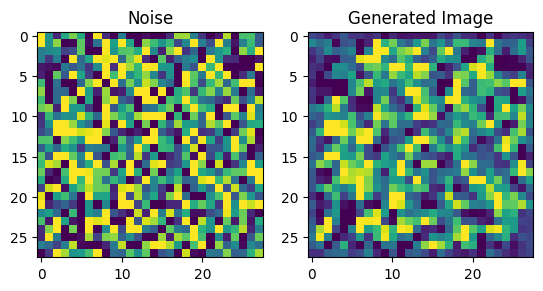

torch.Size([1, 1, 28, 28])


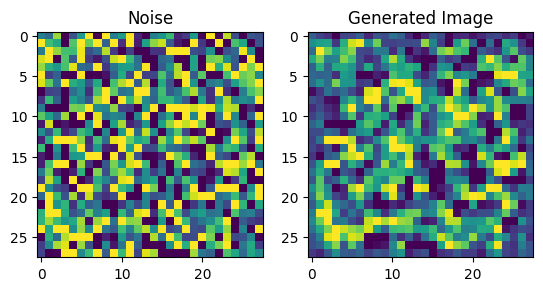

torch.Size([1, 1, 28, 28])


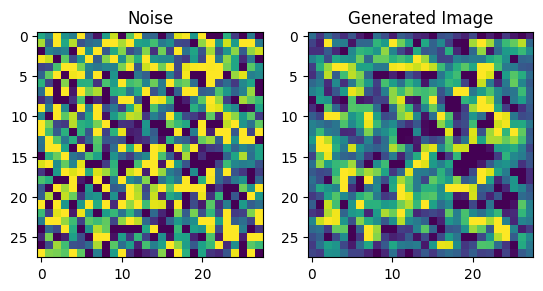

torch.Size([1, 1, 28, 28])


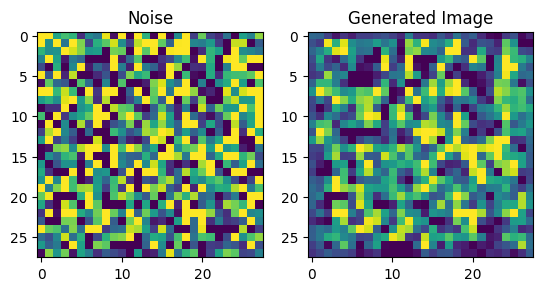

torch.Size([1, 1, 28, 28])


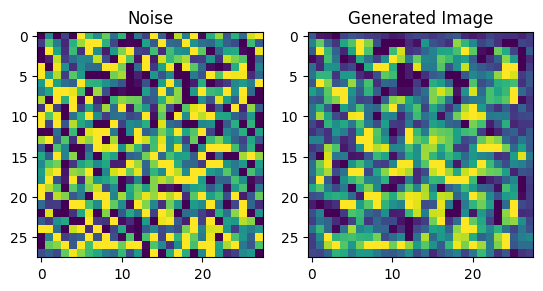

torch.Size([1, 1, 28, 28])


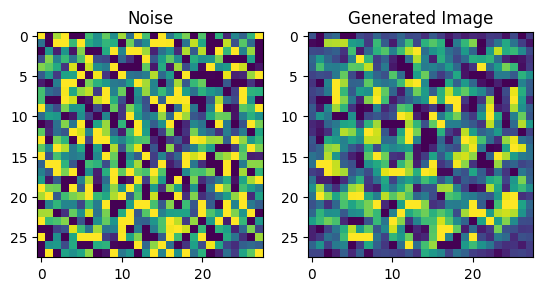

torch.Size([1, 1, 28, 28])


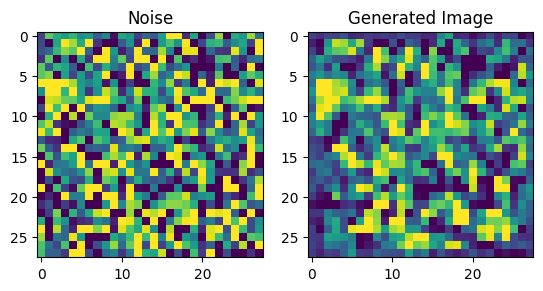

torch.Size([1, 1, 28, 28])


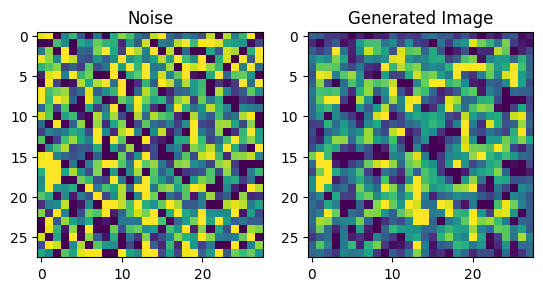

torch.Size([1, 1, 28, 28])


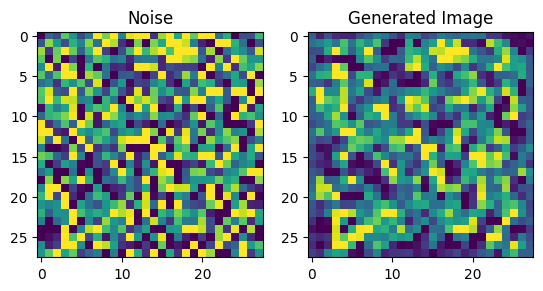

torch.Size([1, 1, 28, 28])


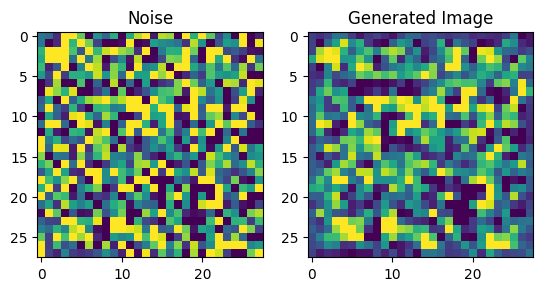

In [ ]:
IMG_CH = 1
IMG_SIZE = 28
model.eval()

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))

for _ in range(10):
    noise = torch.randn((1, IMG_CH, IMG_SIZE, IMG_SIZE), device=device)
    print(noise.shape)
    result = model(noise)
    nrows = 1
    ncols = 2
    samples = {
        "Noise" : noise,
        "Generated Image" : result
    }
    for i, (title, img) in enumerate(samples.items()):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(title)
        show_tensor_image(img)
    plt.show()